# Running Classification Technical Report
Authors: Suyash Kushwaha and Jack Brandt  

Course: CPSC 322

Assignment: Final Project

Date of current version: December 11, 2024

Did you attempt the bonus? Yes

Brief description of project goals:

* Classify running speed based off other metrics
* Learn about random forest classification

## Introduction

For our dataset we are using running and personal wellness data (think stress and heart rate throughout the day) gathered by Jack's Garmin watch over the past few years. Our goal was to predict running speed (i.e., slow, mild, or fast) based on the following attributes:
* Stress
* Average Heart Rate
* Duration

### Findings

The best performing classifier was KNN with an accuracy of .67.

### Imports

In [554]:
# Imports
import importlib
import matplotlib.pyplot as plt
import numpy as np
import pickle # standard library
# mypytable
import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable
# myevaluation
import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
import mysklearn.myevaluation as me
# myutils
import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as mu
from mysklearn.myutils import speed_discretizer,heart_rate_discretizer,stress_discretizer,duration_discretizer

from mysklearn.myclassifiers import MyDecisionTreeClassifier, MyDummyClassifier, MyKNeighborsClassifier, MyNaiveBayesClassifier, MyRandomForestClassifier

from mysklearn.myutils import combine_multiple_files

## Step 1: Data Cleaning

### Preprocessing

The data came as a large number of JSON files grouped into folders. Many of the files and folders were empty, so we began by deleting those. Some of the files contained irrelevant data/non-changing data, such as date of birth and device specs, so we also deleted those. What we were left with was three sets of JSON files, aggregator, fitness, and wellness.

* Aggregator: This contains the most info. It has a list of metrics related to stress, calories, heart rate, and minor metrics related to activity
* Fitness: This contains a list of activities and information about them. All of these activities are runs. Has attributes like distance, speed, heart rate, duration
* Wellness: This mainly contained sleep data

### Cleaning/Joining

Many instances in the dataset are missing values, or are just instances with basically no data.

Additionally, for this step we combine all of the many JSON files into one. First by joining all files within each folder, simply appending them onto each other. Then join the lists from each folder. 

We also opened the CSV's in Excel to guide our decision-making process for this step.

In [555]:
# Cleaning/Joining...
# SLEEP
# 1. load all files

sleep_file_names = [
    "2021-04-23_2021-08-01_96200873_sleepData.csv",
    "2021-08-01_2021-11-09_96200873_sleepData.csv",
    "2021-11-09_2022-02-17_96200873_sleepData.csv",
    "2022-02-17_2022-05-28_96200873_sleepData.csv",
    "2022-05-28_2022-09-05_96200873_sleepData.csv",
    "2022-09-05_2022-12-14_96200873_sleepData.csv",
    "2022-12-14_2023-03-24_96200873_sleepData.csv",
    "2023-03-24_2023-07-02_96200873_sleepData.csv",
    "2023-07-02_2023-10-10_96200873_sleepData.csv",
    "2023-10-10_2024-01-18_96200873_sleepData.csv",
    "2024-01-18_2024-04-27_96200873_sleepData.csv",
    "2024-04-27_2024-08-05_96200873_sleepData.csv",
    "2024-08-05_2024-11-13_96200873_sleepData.csv"
]

full_sleep_table = combine_multiple_files(sleep_file_names, "csv_converted_data/connect_wellness")

#current_table.pretty_print()
# 3. Basic cleaning
full_sleep_table.remove_rows_with_missing_values()
full_sleep_table.remove_rows_where_col_equal_specified(
    full_sleep_table.column_names.index("sleepWindowConfirmationType"),
    'OFF_WRIST'
)

# This is all of our joined sleep data
#full_sleep_table.pretty_print()
full_sleep_table.save_to_file('joined_nullfree_subsets/full_sleep.csv')

In [556]:
# Repeat for other file sets
# ACTIVITY

acitivity_files_names = [
    "jack-brandt@comcast.net_0_summarizedActivities.csv",
    "jack-brandt@comcast.net_1001_summarizedActivities.csv"
]
full_activity_table = combine_multiple_files(acitivity_files_names, "csv_converted_data/connect_fitness")
full_activity_table.save_to_file('joined_nullfree_subsets/full_activity.csv')

In [557]:
# Repeat for other file sets
# AGGREGATOR

aggregator_file_names = [
    "UDSFile_2021-04-23_2021-08-01.csv",
    "UDSFile_2021-08-01_2021-11-09.csv",
    "UDSFile_2021-11-09_2022-02-17.csv",
    "UDSFile_2022-02-17_2022-05-28.csv",
    "UDSFile_2022-05-28_2022-09-05.csv",
    "UDSFile_2022-09-05_2022-12-14.csv",
    "UDSFile_2022-12-14_2023-03-24.csv",
    "UDSFile_2023-03-24_2023-07-02.csv",
    "UDSFile_2023-07-02_2023-10-10.csv",
    "UDSFile_2023-10-10_2024-01-18.csv",
    "UDSFile_2024-01-18_2024-04-27.csv",
    "UDSFile_2024-04-27_2024-08-05.csv",
    "UDSFile_2024-08-05_2024-11-13.csv",
]

full_aggregator_table = combine_multiple_files(aggregator_file_names, "csv_converted_data/connect_aggregator_data")
full_aggregator_table.save_to_file('joined_nullfree_subsets/full_aggregator.csv')

In [558]:
from datetime import datetime, timedelta

# Load the combined tables
full_activity_table = MyPyTable().load_from_file(
    "joined_nullfree_subsets/full_activity.csv"
)
full_sleep_table = MyPyTable().load_from_file("joined_nullfree_subsets/full_sleep.csv")
full_aggregator_table = MyPyTable().load_from_file("joined_nullfree_subsets/full_aggregator.csv")

# full_activity_table doesn't have a calendarDate column, so we need to add it
# by converting the startTimeLocal column to a date
start_time_index = full_activity_table.column_names.index("startTimeLocal")

# Add the column
full_activity_table.column_names.append("calendarDate")

# Add the calendarDate to each row
for data in full_activity_table.data:
    timestamp = data[start_time_index] / 1000
    dt_object = datetime.fromtimestamp(timestamp)
    date = dt_object.strftime("%Y-%m-%d")
    data.append(date)

# Now we can join the tables
fully_joined_table = (full_activity_table.perform_inner_join(
    full_sleep_table, ["calendarDate"]
)).perform_inner_join(
    full_aggregator_table, ["calendarDate"]
)

stress_dict = {}
calendar_date_index = full_aggregator_table.column_names.index("calendarDate")
stress_index = full_aggregator_table.column_names.index("allDayStress/aggregatorList/0/maxStressLevel")


for row in full_aggregator_table.data:
    stress_dict[row[calendar_date_index]] = row[stress_index]

# Add the stress level to the fully joined table
fully_joined_table.column_names.append("prevDayMaxStressLevel")
fully_joined_table_calender_date_index = fully_joined_table.column_names.index("calendarDate")

for row in fully_joined_table.data:
    calendar_date = row[fully_joined_table_calender_date_index]

    # Get the previous calendar date
    prev_calendar_date = (datetime.strptime(calendar_date, "%Y-%m-%d") - timedelta(days=1)).strftime("%Y-%m-%d")

    # Get the stress level for the previous day
    if prev_calendar_date in stress_dict:
        row.append(stress_dict[prev_calendar_date])
    else:
        row.append(None)

fully_joined_table.save_to_file("processed_data/fully_joined.csv")

In [559]:
columns = ["prevDayMaxStressLevel", "avgHr", "duration", "avgSpeed"]
class_column = "avgSpeed"
column_index = {}

for column in columns:
    column_index[column] = fully_joined_table.column_names.index(column)

data = []

for row in fully_joined_table.data:
    data.append([row[column_index[column]] for column in columns])

table = MyPyTable(column_names=columns, data=data)

# Remove rows with missing values
table.remove_rows_with_missing_values()

# Remove runs that are less than 10 minutes
table.remove_row_if(table.get_index("duration"), lambda x: x < 600000)
table.remove_rows_where_col_equal_specified(table.get_index(class_column), 0)

columns_to_extract = columns.copy()
columns_to_extract.remove(class_column)

table.save_to_file("processed_data/processed_data.csv")

X = [[stress_discretizer(row[0]), heart_rate_discretizer(row[1]), duration_discretizer(row[2])] for row in table.get_data_subset(columns_to_extract, False)]
X_undiscretized = table.get_data_subset(columns_to_extract, False)
y = [speed_discretizer(row) for row in table.get_column(class_column)]


table.compute_summary_statistics(table.column_names).pretty_print()

attribute                      min           max           mid            avg         median
---------------------  -----------  ------------  ------------  -------------  -------------
prevDayMaxStressLevel      60        99            79.5          91.8448        92
avgHr                     125       176           150.5         153.036        153
duration               633362         1.3104e+07    6.8687e+06    2.35782e+06    2.24079e+06
avgSpeed                    0.1722    0.630717      0.401458      0.328828       0.328


### Pickling

In [560]:
# Pickling

packaged_obj = (X,y)
outfile = open("knn.p","wb")
pickle.dump(packaged_obj,outfile)
outfile.close()

## Data Analysis

### Dataset information:
Attributes: We've narrowed it down to just stress, average heart, rate, and duration for use in classifiers (even though we started with something more like 2 dozen). We did this simply by using intuition on what would work well (many attributes were basically the same, eg different measures of stress or heart rate), and removed everything else to prevent overfitting. There were 773 instances remaining in this set after we removed those containing nulls.

As for the attributes themselves:
* Stress is a measured by the watch over the course of the data based upon heart rate variability. (Technically we are using max stress level of the previous day as our stress metric). Max value is 100. We believe that this metric is not necessarily reflective of actual stress (otherwise why is Jack hitting 91% of max stress everyday), but it is still useful for predicting running.
* Average heart rate: This is exactly what it sounds like (measured over the course of the run)
* Duration: This is the time duration of the run (measured in milliseconds).

Label:
* Running Speed: Simply the average speed over the course of the run. The unit hear doesn't align with any known common measure of speed, so we presume they are arbitrary (the speed is standardized based upon max possible running speed?)

We discretize all of these into 3 categories respectively. The bounds for discretization were selected somewhat arbitrarily based on using nice numbers and somewhat decent distributions between categories.

### Relevant Summary Statistics:
* Stress: All stress values are between 60 and 99, and the average is about 91.
* Average Heart rate: All HR values are between 125 and 176, and the average is 153
* Duration: All duration values are between 633362 miliseconds (10.55) minutes and 1.3104e+07 miliseconds (218 minutes). With the average being 2.35486e+06 miliseconds (39.25 minutes).
* Running Speed: All runs are between 0.1722 and 0.630717, with the average being 0.328749.

For more summary statistics see the above summary table.

### Data Visualizations:

The following graphs show the attributes discretized into 3 categories (e.g., low, medium, high) as a graph of their number of instances. The first, running speed, is our class, while the rest (stress, average heart rate, and duration) are used for prediction.

Figure 1: A bar chart of running speed distribution, shows that faster runs have a higher frequency than slower runs (based on our discretization)

Figure 2: A bar chart of stress distribution, shows that medium stress is by far the most common

Figure 3: A bar chart of heart rate distribution, shows that medium heart rate followed by low heart rate are much more common than high heart rate.

Figure 4: A bar chart of duration distribution, shows a similar distribution for duration.

While we could adjust the discretization for equal width binning, we believe there is merit in these distributions. Mainly, that for stress, heart rate, and duration, they reflect the real distributions of perceived stress/heart rate/duration levels. And for running speed, since these are all non-competitive runs, it is more important for the run to be above a certain tolerable threshold of speed than for the run to be what could actually be described as fast. Thus, discretizing larger bins for mild and fast puts the distribution more inline with speed in the context of a training run.

### Running Speed

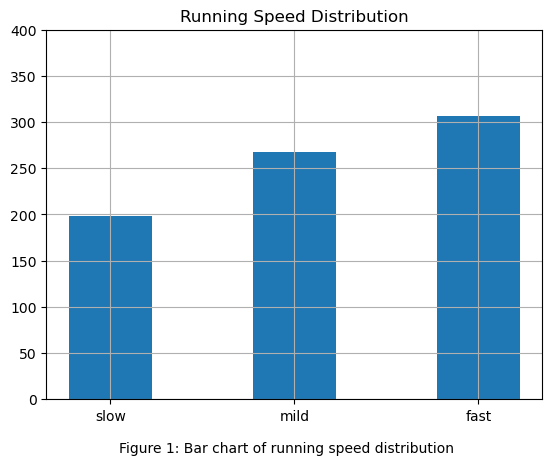

In [561]:
# reset figure
plt.figure()

# define x and y values
xs = [1, 2, 3]
ys = [y.count('slow'), y.count('mild'), y.count('fast')]

# calculate a range (make y a bit bigger)
xrng = np.arange(len(xs))
yrng = np.arange(0, max(ys)+100, 50)

# create the bar chart (.45 relativebar width)
plt.bar(xrng, ys, 0.45, align="center")
# note: default alignment is center

# define x and y ranges (and value labels)
plt.xticks(xrng, ["slow", "mild", "fast"])
plt.yticks(yrng)
# turn on the background grid
plt.grid(True)
plt.title("Running Speed Distribution")
plt.figtext(.5, 0, "Figure 1: Bar chart of running speed distribution", ha="center")
plt.show()

### Stress

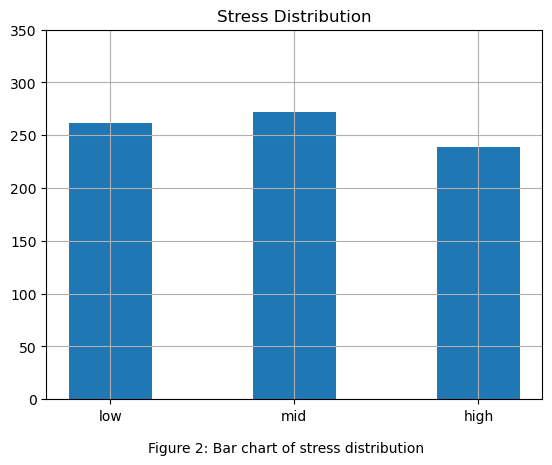

In [562]:
# reset figure
plt.figure()

hist_y = [x[0] for x in X]
ys = [hist_y.count('low'), hist_y.count('mid'), hist_y.count('high')]

# calculate a range (make y a bit bigger)
xrng = np.arange(len(xs))
yrng = np.arange(0, max(ys)+100, 50)

# create the bar chart (.45 relativebar width)
plt.bar(xrng, ys, 0.45, align="center")
# note: default alignment is center

# define x and y ranges (and value labels)
plt.xticks(xrng, ["low", "mid", "high"])
plt.yticks(yrng)
# turn on the background grid
plt.grid(True)
plt.title("Stress Distribution")
plt.figtext(.5, 0, "Figure 2: Bar chart of stress distribution", ha="center")
plt.show()

### Average HR

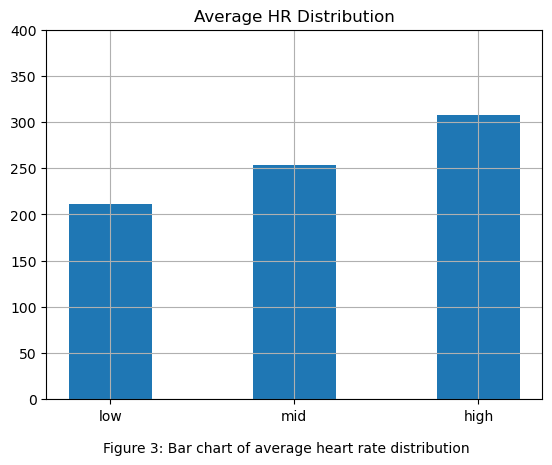

In [563]:
# reset figure
plt.figure()

hist_y = [x[1] for x in X]
ys = [hist_y.count('low'), hist_y.count('mid'), hist_y.count('high')]

# calculate a range (make y a bit bigger)
xrng = np.arange(len(xs))
yrng = np.arange(0, max(ys)+100, 50)

# create the bar chart (.45 relativebar width)
plt.bar(xrng, ys, 0.45, align="center")
# note: default alignment is center

# define x and y ranges (and value labels)
plt.xticks(xrng, ["low", "mid", "high"])
plt.yticks(yrng)
# turn on the background grid
plt.grid(True)
plt.title("Average HR Distribution")
plt.figtext(.5, 0, "Figure 3: Bar chart of average heart rate distribution", ha="center")
plt.show()

### Duration

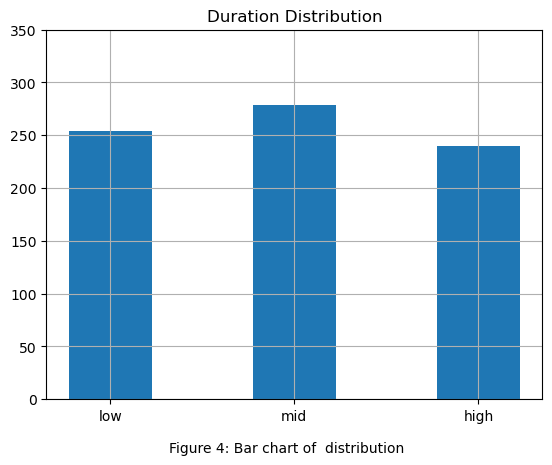

In [564]:
# reset figure
plt.figure()

hist_y = [x[2] for x in X]
ys = [hist_y.count('low'), hist_y.count('mid'), hist_y.count('high')]

# calculate a range (make y a bit bigger)
xrng = np.arange(len(xs))
yrng = np.arange(0, max(ys)+100, 50)

# create the bar chart (.45 relativebar width)
plt.bar(xrng, ys, 0.45, align="center")
# note: default alignment is center

# define x and y ranges (and value labels)
plt.xticks(xrng, ["low", "mid", "high"])
plt.yticks(yrng)
# turn on the background grid
plt.grid(True)
plt.title("Duration Distribution")
plt.figtext(.5, 0, "Figure 4: Bar chart of  distribution", ha="center")
plt.show()

## Classification Results

We tested classification with dummy (predict most frequent), KNN, naive bayes, decision tree, and random forest models. Out of all of these, KNN performed the best.

As is standard, we used stratified cross fold validation (in this case with k=10). We measured: accuracy, error rate, precision, recall, f1, along with an included confusion matrix and classification report.

Sometimes it can be difficult to decide which model is the best based upon accuracy vs precision vs recall. But the accuracy (mid 60s) and precision (mid 70s) for KNN was far ahead of the other models (which had accuracies in the 40s and precisions in the 50s), making it an easy winner.

Note: We expected random forest classifier to somehow perform well, since we learned that it was supposed to be an upgraded version of decision tree models. However, this was not true in our case (even though it might be true for a bunch of other datasets). We tried testing various parameter values for N, M, and F, but never saw results that did much better than a standard decision tree.

In [565]:
#Set up models # Add more from myclassifiers if time
dummy_model = MyDummyClassifier() # Import these from myclassifiers
knn_model = MyKNeighborsClassifier()
bayes_model = MyNaiveBayesClassifier()
tree_model = MyDecisionTreeClassifier()
forest_model = MyRandomForestClassifier()

labels = ['slow','mild','fast']
pos_label='fast'

# Repeat these following two lines for each possible model
metrics, confusion, clas_repor = me.get_metrics_and_conf_matrix_and_report(dummy_model,10,X,y,labels,pos_label,'Running')
mu.report_metrics_and_confusion('Dummy',metrics, confusion,
    clas_repor)

Dummy Summary Results
1.
    Accuracy: 0.39715394566623546
    Error Rate: 0.6028460543337646
2.
    Precision: 0.39715394566623546
    Recall: 1.0
    F1 measure: 0.5685185185185185
3. Confusion Matrix:
Running      slow    mild    fast    Total    Recognition (%)
---------  ------  ------  ------  -------  -----------------
slow            0       0     198      198                  0
mild            0       0     268      268                  0
fast            0       0     307      307                100
(Bonus) Classification Report:
              precision    recall    f1-score    support
------------  -----------  --------  ----------  ---------
slow          0.0          0.0       0           198
mild          0.0          0.0       0           268
fast          0.4          1.0       0.57        307

micro avg     0.4          1.0       0.57        773
macro avg     0.13         0.33      0.19        773
weighted avg  0.16         0.4       0.23        773


In [566]:
metrics, confusion, clas_repor = me.get_metrics_and_conf_matrix_and_report(knn_model,10,X_undiscretized,y,labels,pos_label,'Running')
mu.report_metrics_and_confusion('KNN',metrics, confusion,
    clas_repor)

KNN Summary Results
1.
    Accuracy: 0.6882276843467011
    Error Rate: 0.3117723156532989
2.
    Precision: 0.7547169811320755
    Recall: 0.7817589576547231
    F1 measure: 0.7679999999999999
3. Confusion Matrix:
Running      slow    mild    fast    Total    Recognition (%)
---------  ------  ------  ------  -------  -----------------
slow          114      51      33      198            57.5758
mild           45     178      45      268            66.4179
fast           27      40     240      307            78.1759
(Bonus) Classification Report:
              precision    recall    f1-score    support
------------  -----------  --------  ----------  ---------
slow          0.61         0.58      0.59        198
mild          0.66         0.66      0.66        268
fast          0.75         0.78      0.77        307

accuracy                             0.69        773
macro avg     0.68         0.67      0.67        773
weighted avg  0.69         0.69      0.69        773


In [567]:
metrics, confusion, clas_repor = me.get_metrics_and_conf_matrix_and_report(MyNaiveBayesClassifier(),10,X,y,labels,pos_label,'Running')
mu.report_metrics_and_confusion('Bayes',metrics, confusion,
    clas_repor)

Bayes Summary Results
1.
    Accuracy: 0.4644243208279431
    Error Rate: 0.535575679172057
2.
    Precision: 0.5
    Recall: 0.6482084690553745
    F1 measure: 0.5645390070921986
3. Confusion Matrix:
Running      slow    mild    fast    Total    Recognition (%)
---------  ------  ------  ------  -------  -----------------
slow           84      46      68      198            42.4242
mild           61      76     131      268            28.3582
fast           47      61     199      307            64.8208
(Bonus) Classification Report:
              precision    recall    f1-score    support
------------  -----------  --------  ----------  ---------
slow          0.44         0.42      0.43        198
mild          0.42         0.28      0.34        268
fast          0.5          0.65      0.56        307

accuracy                             0.46        773
macro avg     0.45         0.45      0.44        773
weighted avg  0.45         0.46      0.45        773


In [568]:
metrics, confusion, clas_repor = me.get_metrics_and_conf_matrix_and_report(tree_model,10,X,y,labels,pos_label,'Running')
mu.report_metrics_and_confusion('Tree',metrics, confusion,
    clas_repor)

Tree Summary Results
1.
    Accuracy: 0.4799482535575679
    Error Rate: 0.5200517464424321
2.
    Precision: 0.5114503816793893
    Recall: 0.6547231270358306
    F1 measure: 0.5742857142857143
3. Confusion Matrix:
Running      slow    mild    fast    Total    Recognition (%)
---------  ------  ------  ------  -------  -----------------
slow           68      54      76      198            34.3434
mild           50     102     116      268            38.0597
fast           33      73     201      307            65.4723
(Bonus) Classification Report:
              precision    recall    f1-score    support
------------  -----------  --------  ----------  ---------
slow          0.45         0.34      0.39        198
mild          0.45         0.38      0.41        268
fast          0.51         0.65      0.57        307

accuracy                             0.48        773
macro avg     0.47         0.46      0.46        773
weighted avg  0.47         0.48      0.47        773


In [569]:
metrics, confusion, clas_repor = me.get_metrics_and_conf_matrix_and_report_forest(forest_model,10,X,y,labels,pos_label,'Running', N=13, M=11, F=2)
mu.report_metrics_and_confusion('Forest',metrics, confusion,
    clas_repor)

Forest Summary Results
1.
    Accuracy: 0.46054333764553684
    Error Rate: 0.5394566623544632
2.
    Precision: 0.5024038461538461
    Recall: 0.6807817589576547
    F1 measure: 0.578146611341632
3. Confusion Matrix:
Running      slow    mild    fast    Total    Recognition (%)
---------  ------  ------  ------  -------  -----------------
slow           83      56      59      198            41.9192
mild           61      96     111      268            35.8209
fast           48      88     171      307            55.7003
(Bonus) Classification Report:
              precision    recall    f1-score    support
------------  -----------  --------  ----------  ---------
slow          0.42         0.41      0.42        198
mild          0.4          0.25      0.3         268
fast          0.5          0.68      0.58        307

accuracy                             0.46        773
macro avg     0.44         0.45      0.43        773
weighted avg  0.45         0.46      0.44        773


## Web App

We developed a flask app that uses our KNN model to predict running speed. It has a user interface. It is hosted by Render.

Our flask app: https://dataalg-final-project-running.onrender.com/

## Conclusion

Review: We gathered and cleaned data on running speed vs other metrics, fed it into a bunch of models, determined KNN was the best, and used the KNN model to deploy a web app for making predictions about running speed.

Dataset summary: We used previous day max stress, average heart rate, and duration, discretized these each into 3 possible values. Then used them to predict running slow, mild, or fast. The biggest inherent challenge with the dataset was all the cleaning (e.g., converting to csv, removing all the misc. files, figuring out what was relevent, removing the instances with missing values). The second biggest challenge with this is that the correlation between our attributes and class isn't that strong, so we were only able to get an accuracy of 68%.

Classification: We tested multiple classifiers and compared based on accuracy and precision, but KNN was the best by far. So we deployed KNN for classification.

Performance: 
* Accuracy: 0.68
* Error Rate: 0.31
* Precision: 0.75
* Recall: 0.78
* F1 measure: 0.76
As you can see, all metrics are good, albeit the accuracy is on the lower side of good, but it is far better than dummy predict. Which had an error Rate of 0.60 and a precision of 0.39

Ideas for Improvement:
* Chunk data by time: Runs from 5 years ago are maybe slower, then runs today.
* Utilize an aggregate model involving KNN along with other kinds of models. Other models tend to perform worse than KNN, but there are some cases where they seem to do better, so it makes sense to find a way to include them.
* Add another dataset, like weather, to get a bigger picture of what might be affecting running speed. E.G., If it's icy out, than probably runs are going to be a lot slower.

## Acknowledgments

* https://www.convertcsv.com/json-to-csv.htm was used for converting our initial json files to csv's. We believe writing our own json to csv convertor would have been doable, but outside of the scope of this project and deadline
* Also, Jack has been making a flask website for his database final so he read all of the w3 tutorials on HTML. The two web things are completely different, but he's using the same css file for both projects (or at least that's what we started with)
* No other outside resources were used, other than simply searching Google and Stack Overflow when there was a question about how to do/fix something.